In [1]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import json
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

In [2]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('../../data/train.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


## Answer
비율 확인

In [5]:
# 3. 데이터 분리 (4지선다 vs 5지선다)
df['len_choices'] = df['choices'].apply(len)
df_4 = df[df['len_choices'] == 4].copy()
df_5 = df[df['len_choices'] == 5].copy()

print(f"전체 데이터 개수: {len(df)}")
print(f"4지선다 문제 개수: {len(df_4)}")
print(f"5지선다 문제 개수: {len(df_5)}")

전체 데이터 개수: 2031
4지선다 문제 개수: 792
5지선다 문제 개수: 1239


In [6]:
# ---------------------------------------------------------
# 4. 정답 비율 확인 함수 정의
# ---------------------------------------------------------
def analyze_answer_distribution(target_df, title):
    """
    특정 데이터프레임의 정답 분포와 비율을 계산하고 출력합니다.
    """
    print(f"\n{'='*10} {title} 정답 분포 {'='*10}")
    
    # 정답별 개수 및 비율 계산
    dist = target_df['answer'].value_counts().sort_index()
    ratio = (target_df['answer'].value_counts(normalize=True) * 100).sort_index()
    
    # 결과 시각화를 위한 DataFrame 생성
    summary = pd.DataFrame({
        'Count': dist,
        'Ratio (%)': ratio.round(2)
    })
    
    display(summary) # ipynb에서 표 형태로 출력
    return summary

In [9]:
# 5. 각 그룹별 분석 실행
dist = analyze_answer_distribution(df, "모든 데이터")
dist_4 = analyze_answer_distribution(df_4, "4지선다(지식형)")
dist_5 = analyze_answer_distribution(df_5, "5지선다(추론형)")


========== 모든 데이터 정답 분포 ==========


,Count,Ratio (%)
answer,,
1,948,46.68
2,450,22.16
3,319,15.71
4,283,13.93
5,31,1.53



========== 4지선다(지식형) 정답 분포 ==========


,Count,Ratio (%)
answer,,
1,183,23.11
2,185,23.36
3,203,25.63
4,221,27.90



========== 5지선다(추론형) 정답 분포 ==========


,Count,Ratio (%)
answer,,
1,765,61.74
2,265,21.39
3,116,9.36
4,62,5.00
5,31,2.50


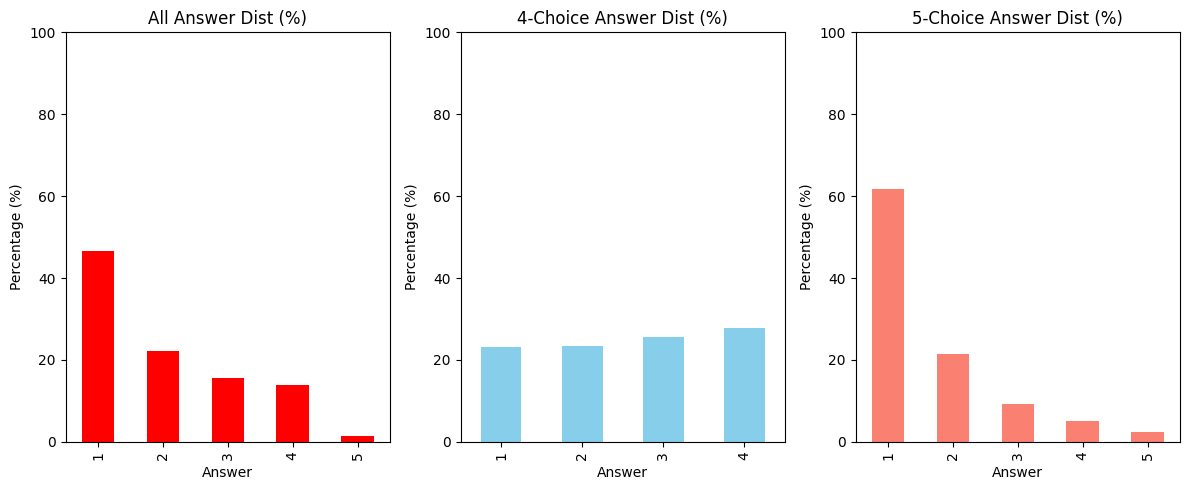

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

dist['Ratio (%)'].plot(kind='bar', ax=axes[0], color='red', title='All Answer Dist (%)')
dist_4['Ratio (%)'].plot(kind='bar', ax=axes[1], color='skyblue', title='4-Choice Answer Dist (%)')
dist_5['Ratio (%)'].plot(kind='bar', ax=axes[2], color='salmon', title='5-Choice Answer Dist (%)')

for ax in axes:
    ax.set_xlabel('Answer')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 100) # 비율 비교를 위해 y축 고정

plt.tight_layout()
plt.show()

## Paragraph

### 1. 중복 분석
train, eval 나눌 때 같은 지문에 해당하는 문제들은 묶어서 나눠야함

In [10]:
# paragraph 중복 분석
paragraph_counts = df['paragraph'].value_counts()

print("=== Paragraph 중복 현황 ===")
print(f"전체 문제 수: {len(df)}")
print(f"고유한 paragraph 수: {df['paragraph'].nunique()}")
print(f"중복된 paragraph 수: {(paragraph_counts > 1).sum()}")
print(f"\n평균 문제 수 (paragraph당): {paragraph_counts.mean():.2f}")
print(f"최대 문제 수 (하나의 paragraph): {paragraph_counts.max()}")

print("\n=== Paragraph별 문제 개수 분포 ===")
print(paragraph_counts.value_counts().sort_index())

# print("\n=== 가장 많은 문제를 가진 paragraph Top 5 ===")
# print(paragraph_counts.head())



=== Paragraph 중복 현황 ===
전체 문제 수: 2031
고유한 paragraph 수: 1871
중복된 paragraph 수: 122

평균 문제 수 (paragraph당): 1.09
최대 문제 수 (하나의 paragraph): 5

=== Paragraph별 문제 개수 분포 ===
count
1    1749
2      93
3      22
4       5
5       2
Name: count, dtype: int64


### 2. 길이 분석

전체 지문 평균 길이: 735.32
전체 지문 중앙 길이: 699.00


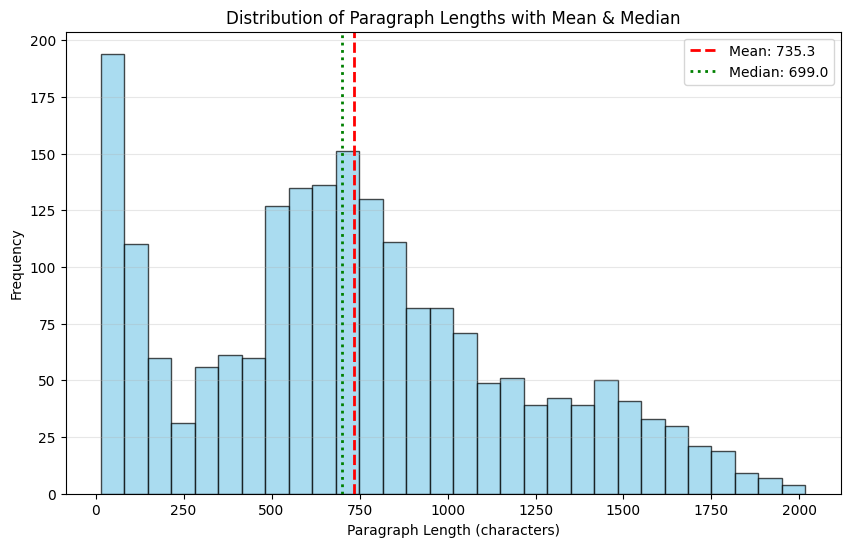

In [15]:
# 1. 지문 길이 계산 및 통계량 산출
df['paragraph_length'] = df['paragraph'].apply(len)
mean_len = df['paragraph_length'].mean()
median_len = df['paragraph_length'].median()

# 통계치 출력
print(f"전체 지문 평균 길이: {mean_len:.2f}")
print(f"전체 지문 중앙 길이: {median_len:.2f}")

# 2. 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(df['paragraph_length'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

# 평균(Mean)과 중앙값(Median)을 그래프에 표시
plt.axvline(mean_len, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_len:.1f}')

plt.title('Distribution of Paragraph Lengths with Mean & Median')
plt.xlabel('Paragraph Length (characters)')
plt.ylabel('Frequency')
plt.legend() # 범례 추가
plt.grid(axis='y', alpha=0.3)
plt.show()

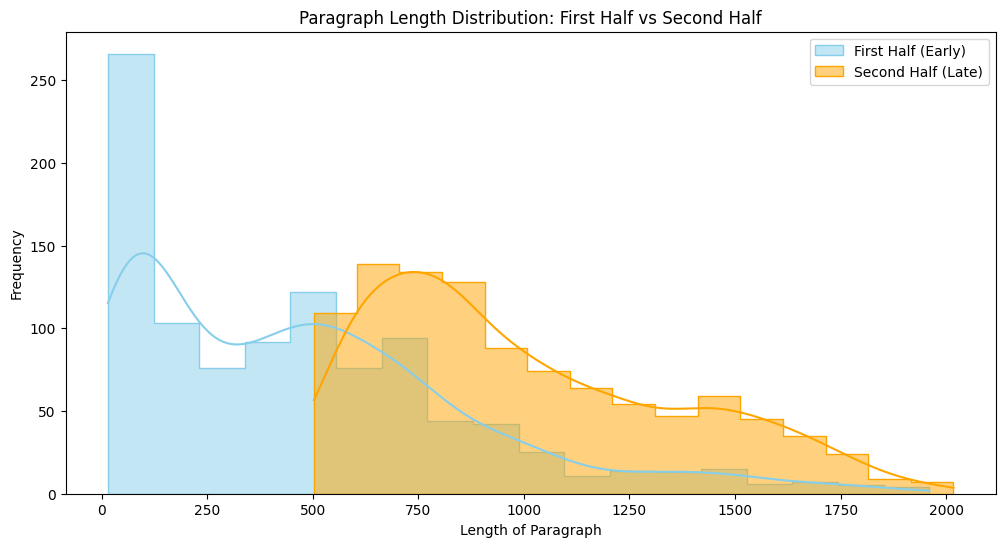

전반부 평균 길이: 468.38
후반부 평균 길이: 1002.01


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 지문 길이 계산
df['para_len'] = df['paragraph'].str.len()

# 2. 데이터 반으로 나누기
mid_idx = len(df) // 2
first_half = df.iloc[:mid_idx]
second_half = df.iloc[mid_idx:]

# 3. 그래프 시각화
plt.figure(figsize=(12, 6))

# 전반부 데이터 분포
sns.histplot(first_half['para_len'], color='skyblue', label='First Half (Early)', kde=True, element="step")
# 후반부 데이터 분포
sns.histplot(second_half['para_len'], color='orange', label='Second Half (Late)', kde=True, element="step")

plt.title('Paragraph Length Distribution: First Half vs Second Half')
plt.xlabel('Length of Paragraph')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 간단한 통계치 확인
print(f"전반부 평균 길이: {first_half['para_len'].mean():.2f}")
print(f"후반부 평균 길이: {second_half['para_len'].mean():.2f}")

In [17]:
# 최소 길이 계산
min_len_second = second_half['paragraph_length'].min()

print(f"후반부 지문의 최소 길이: {min_len_second}자")

후반부 지문의 최소 길이: 503자


In [12]:
# # 1. 100자 정도인 지문 5개 추출
# short_samples = df.iloc[(df['paragraph_length']).abs().argsort()[:10]]

# # 2. 750자 정도인 지문 5개 추출
# long_samples = df.iloc[(df['paragraph_length'] - 750).abs().argsort()[:10]]

# print("=== [약 100자 내외 지문] ===")
# for i, row in short_samples.iterrows():
#     print(f"길이: {row['paragraph_length']} | 내용: {row['paragraph'][:100]}...")

# print("\n" + "="*50 + "\n")

# print("=== [약 750자 내외 지문] ===")
# for i, row in long_samples.iterrows():
#     print(f"길이: {row['paragraph_length']} | 내용: {row['paragraph'][:100]}...")

## Question

In [6]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

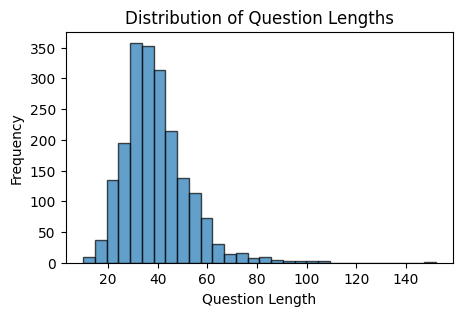

In [7]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

In [8]:
# 질문 시작 단어로 유형 파악
def classify_question_type(question):
    question_lower = question.lower().strip()
    if question_lower.startswith(('what', '무엇', '어떤')):
        return 'what'
    elif question_lower.startswith(('why', '왜', '어째서')):
        return 'why'
    elif question_lower.startswith(('how', '어떻게', '방법')):
        return 'how'
    elif question_lower.startswith(('when', '언제')):
        return 'when'
    elif question_lower.startswith(('where', '어디')):
        return 'where'
    elif question_lower.startswith(('who', '누구')):
        return 'who'
    else:
        return 'other'

df['question_type'] = df['question'].apply(classify_question_type)
print(df['question_type'].value_counts())

question_type
other    2025
what        3
who         2
why         1
Name: count, dtype: int64


In [14]:
def classify_question_difficulty(question):
    question = question.strip()
    
    # 고난이도 키워드
    high_difficulty_keywords = [
        '설명', '추론', '이유', '바탕으로', '관점', '입장', '태도', 
        '파악', '비판', '분석', '해석', '평가', '근거'
    ]
    
    # 저난이도 키워드
    low_difficulty_keywords = [
        '무엇', '누구', '언제', '어디', '몇', '어느'
    ]
    
    # 고난이도 체크
    for keyword in high_difficulty_keywords:
        if keyword in question:
            return 'high'
    
    # 저난이도 체크
    for keyword in low_difficulty_keywords:
        if keyword in question:
            return 'low'
    
    return 'medium'

df['difficulty_level'] = df['question'].apply(classify_question_difficulty)

# 난이도 분포 확인
print(df['difficulty_level'].value_counts())
print(f"\n난이도별 비율:")
print(df['difficulty_level'].value_counts(normalize=True) * 100)

difficulty_level
low       1059
medium     523
high       449
Name: count, dtype: int64

난이도별 비율:
difficulty_level
low       52.141802
medium    25.750862
high      22.107336
Name: proportion, dtype: float64


In [16]:
from collections import Counter
import re

# 모든 질문에서 단어 추출 (한글/영어)
all_words = []
for question in df['question']:
    words = re.findall(r'[가-힣]+|[a-zA-Z]+', question)
    all_words.extend(words)

# 가장 많이 나오는 단어
word_counts = Counter(all_words)
print("가장 많이 나오는 단어 TOP 20:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}번")

가장 많이 나오는 단어 TOP 20:
무엇인가: 822번
중: 461번
다음: 363번
것은: 353번
가장: 319번
무엇입니까: 194번
이유는: 173번
대한: 164번
어떤: 163번
이: 148번
이름은: 115번
있는: 114번
주된: 114번
얼마인가: 110번
위: 101번
의: 97번
주요: 95번
잘: 95번
옳은: 87번
년: 84번


In [22]:
# 처음 10개와 마지막 10개의 question 확인
print("=" * 80)
print("처음 10개의 질문")
print("=" * 80)
for idx, question in enumerate(df['choices'].head(30), 1):
    print(f"\n[{idx}] {question}")

print("\n\n")
print("=" * 80)
print("마지막 10개의 질문")
print("=" * 80)
for idx, question in enumerate(df['choices'].tail(30), 1):
    print(f"\n[{len(df) - 10 + idx}] {question}")

처음 10개의 질문

[1] ['ㄱ, ㄴ', 'ㄱ, ㄷ', 'ㄴ, ㄹ', 'ㄷ, ㄹ']

[2] ['고려 문종 때에 남경(南京)으로 승격되었다.', '종루(鐘樓), 이현, 칠패 등에서 상업활동이 이루어졌다.', '정도전은 궁궐 전각(殿閣)과도성성문 등의 이름을 지었다.', '성곽은 거중기 등을 이용하여 약 2년 만에 완성되었다.']

[3] ['이곳에 대장도감을 설치하여 재조대장경을 만들었다.', '지눌이 이곳에서 수선사 결사운동을 펼쳤다.', '망이 ․망소이가 이곳에서 봉기하였다.', '몽골이 이곳에 동녕부를 두었다.']

[4] ['살수에서 수의 군대를 물리쳤다 .', '김춘추 의 신라 왕위 계승을 지원하였다 .', '청해진을 설치하고 해상 무역을 전개하였다 .', '대가야를 정벌하여 낙동강 유역을 확보하였다 .']

[5] ['사창제를 실시하였다 .', '대전회통을 편찬하였다 .', '비변사의 기능을 강화하였다 .', '통상 수교 거부 정책을 추진하였다 .']

[6] ['나 당연합군의 공격으로 멸망하였다 .', '9주 5소경의 지방 행정 구역을 두었다 .', '중앙 행정 기구로 3성 6부를 설치하였다 .', '고구려의 수도였던 평양을 서경으로 삼았다 .']

[7] ['(가)→(라)→(나)→(다)', '(나)→(다)→(가)→(라)', '(다)→(나)→(가)→(라)', '(라)→(다)→(가)→(나) ']

[8] ['시 전의 물가를 감독하는 임무를 담당하였다 .', '국가재정의 출납과 회계 업무를 총괄하였다 .', '불법적으로 점유된 토지와 노비를 조사하였다 .', '부족한 녹봉을 보충하고자 관료에게 녹과 전을 지급하였다 .']

[9] ['일본은 동양척식 주식회사를 설립하였다.', '일본이 간도를 청에 귀속하는 협약을 체결하였다.', '유생의 병장 중심으로 13도 창의군을 결성하였다.', '대한제국의 외교권을 박탈하고 통감부를 설치하였다.']

[10] ['예안향약을 만들었다 .', '동호문답 을 저술하였다 .', '백운동 서원을 건립하였다 .', '왕

In [24]:
# choices의 개수 계산
df['num_choices'] = df['choices'].apply(len)

# 4지선다에서 5지선다로 바뀌는 지점 찾기
transition_indices = []

for i in range(len(df) - 1):
    if df.iloc[i]['num_choices'] == 4 and df.iloc[i + 1]['num_choices'] == 5:
        transition_indices.append(i + 1)  # 5지선다가 시작되는 인덱스

print("=" * 80)
print("4지선다 → 5지선다 전환 지점")
print("=" * 80)

if transition_indices:
    for trans_idx in transition_indices:
        print(f"\n전환 인덱스: {trans_idx}")
        print(f"[이전] 인덱스 {trans_idx - 1}: {df.iloc[trans_idx - 1]['num_choices']}지선다")
        print(f"  ID: {df.iloc[trans_idx - 1]['id']}")
        print(f"  선지: {df.iloc[trans_idx - 1]['choices'][:50]}...")
        print(f"\n[전환] 인덱스 {trans_idx}: {df.iloc[trans_idx]['num_choices']}지선다")
        print(f"  ID: {df.iloc[trans_idx]['id']}")
        print(f"  선지: {df.iloc[trans_idx]['choices'][:50]}...")
        print("-" * 80)
else:
    print("4지선다에서 5지선다로 전환되는 지점이 없습니다.")

# 전체 분포 확인
print("\n\n선택지 개수 분포:")
print(df['num_choices'].value_counts().sort_index())

print("\n\n4지선다와 5지선다 비율:")
print(df['num_choices'].value_counts(normalize=True) * 100)

4지선다 → 5지선다 전환 지점

전환 인덱스: 792
[이전] 인덱스 791: 4지선다
  ID: generation-for-nlp-1379
  선지: ['가나의 왕의 신하들은 소금 채굴에 종사하고 있다.', '가나인들은 고기와 가죽을 얻기 위해 소를 키웠다.', '가나의 왕은 소금과 구리 수출입에 세금을 부과했다.', '가나인들은 자급자족하는 농업 경제를 갖고 있었다.']...

[전환] 인덱스 792: 5지선다
  ID: generation-for-nlp-1380
  선지: ['부산광역시', '과학기술정보통신부', '중소벤처기업부', '산업통상자원부', '교육부']...
--------------------------------------------------------------------------------


선택지 개수 분포:
num_choices
4     792
5    1239
Name: count, dtype: int64


4지선다와 5지선다 비율:
num_choices
5    61.004431
4    38.995569
Name: proportion, dtype: float64
